In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection

/content/drive/My Drive/Practice/Breast_Cancer_Detection


In [3]:
data = './'

In [ ]:
!unzip -q Breast_cancer.zip -d $data

In [4]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer

/content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer


**Import Lib**

In [5]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from pickle import dump, load

**Load data and convert to np.array**

In [6]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

**Prepare for train set**

In [7]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer/train

/content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer/train


In [ ]:
benign_train = np.array(Dataset_loader('./benign',224))
malignant_train = np.array(Dataset_loader('./malignant', 224))
X_train = np.concatenate((benign_train, malignant_train), axis = 0)

**Prepare for validation set**

In [8]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer/validation

/content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer/validation


In [ ]:
benign_valid = np.array(Dataset_loader('./benign', 224))
malignant_valid = np.array(Dataset_loader('./malignant', 224))
X_valid = np.concatenate((benign_valid, malignant_valid), axis=0)

**Prepare for test set**

In [9]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer/test

/content/drive/My Drive/Practice/Breast_Cancer_Detection/Breast_cancer/test


In [ ]:
benign_test = np.array(Dataset_loader('./benign',224))
malignant_test = np.array(Dataset_loader('./malignant', 224))
X_test = np.concatenate((benign_test, malignant_test), axis=0)

In [10]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection

/content/drive/My Drive/Practice/Breast_Cancer_Detection


**Encoded for Data**

In [ ]:
with open('train.pkl', 'wb') as encoded_train:
    dump(X_train, encoded_train)
with open('validation.pkl', 'wb') as encoded_validation:
  dump(X_valid, encoded_validation)
with open('test.pkl', 'wb') as encoded_test:
  dump(X_test, encoded_test)

**Load data from encoded**

In [11]:
X_train = load(open("./train.pkl", "rb"))

X_valid = load(open("./validation.pkl", "rb"))

X_test = load(open("./test.pkl", "rb"))

In [12]:
#label for train
benign_train_label = np.zeros(1454)
malignant_train_label = np.ones(3249)
y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)

#label for validation
benign_valid_label = np.zeros(511)
malignant_valid_label = np.ones(1093)
y_valid = np.concatenate((benign_valid_label, malignant_valid_label), axis = 0)

#label for test
benign_test_label = np.zeros(515)
malignant_test_label = np.ones(1087)
y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)

**Create label**

In [ ]:
#label for train
benign_train_label = np.zeros(len(benign_train))
malignant_train_label = np.ones(len(malignant_train))
y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)

#label for validation
benign_valid_label = np.zeros(len(benign_valid))
malignant_valid_label = np.ones(len(malignant_valid))
y_valid = np.concatenate((benign_valid_label, malignant_valid_label), axis = 0)

#label for test
benign_test_label = np.zeros(len(benign_test))
malignant_test_label = np.ones(len(malignant_test))
y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)

**Đảo trật tự ảnh và label của chúng**

In [13]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)

X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_valid.shape[0])
np.random.shuffle(s)

X_valid = X_valid[s]
y_valid = y_valid[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)

X_test = X_test[s]
y_test = y_test[s]

#one-hot encoded
y_train = to_categorical(y_train, num_classes= 2)
y_valid = to_categorical(y_valid, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

**Show some picture**

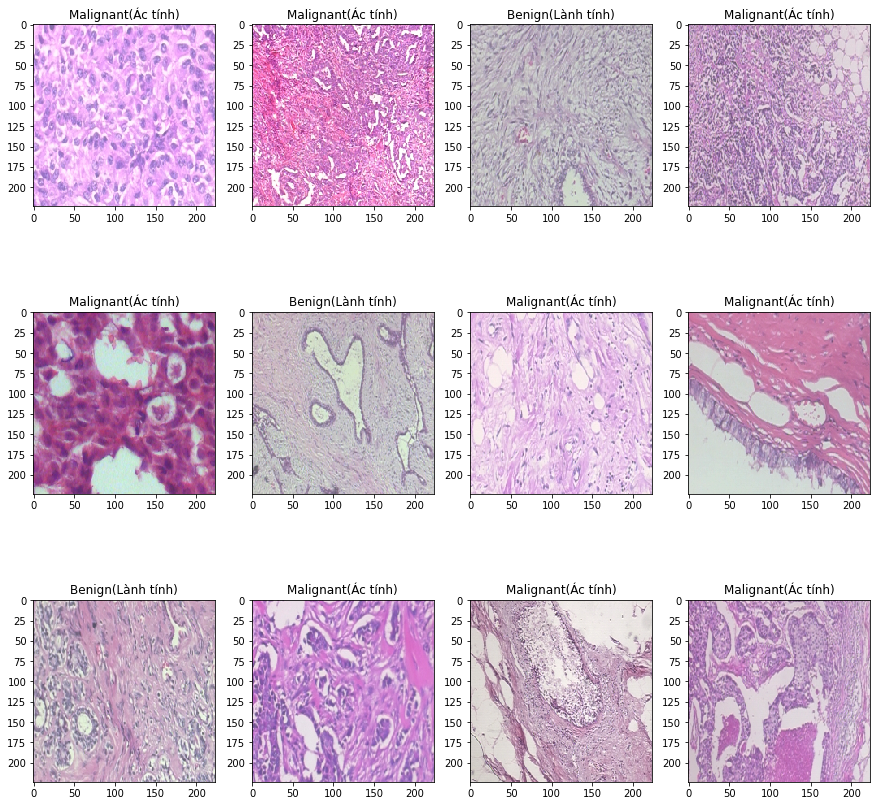

In [14]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i+248]) == 0:
        ax.title.set_text('Benign(Lành tính)')
    else:
        ax.title.set_text('Malignant(Ác tính)')
    plt.imshow(X_train[i+248], interpolation='nearest')
plt.show()

In [15]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

**Define and Compile Model**

In [32]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy'])
    return model

In [33]:
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3))

In [34]:
model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1920)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [35]:
cd /content/drive/My Drive/Practice/Breast_Cancer_Detection

/content/drive/My Drive/Practice/Breast_Cancer_Detection


In [36]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

**Fit Model**

In [ ]:
N = model.fit_generator(
    train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[learn_control, checkpoint])

**Save weight**

In [ ]:
model.save_weights("custom_model.h5")

**Load weight**

In [21]:
model.load_weights("custom_model.h5")

**Visualize Loss and Accuracy**

**Cách 1**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


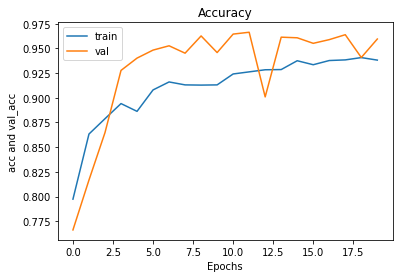

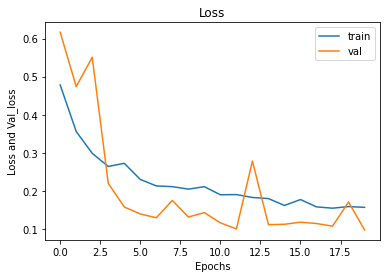

In [38]:
print(N.history.keys())
fig = plt.figure()

#plot accuracy and val_accuracy
plt.plot(N.history['accuracy'])
plt.plot(N.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('acc and val_acc')
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
#plot loss and val_loss
plt.plot(N.history['loss'])
plt.plot(N.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss and Val_loss')
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

**Cách 2**

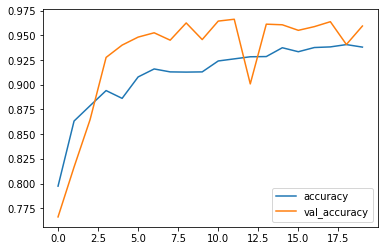

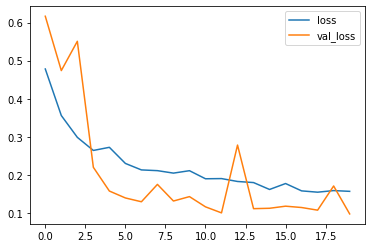

In [39]:
history_df = pd.DataFrame(N.history)
history_df[['accuracy', 'val_accuracy']].plot()

history_df = pd.DataFrame(N.history)
history_df[['loss', 'val_loss']].plot()

**Evaluate Model**

In [22]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %.3f' % acc)

51/51 - 16s - loss: 0.0768 - accuracy: 0.9732
Accuracy: 0.973


**Predict**

In [23]:
y_val_pred = model.predict(X_valid)

In [24]:
accuracy_score(np.argmax(y_valid, axis=1), np.argmax(y_val_pred, axis=1))

0.9738154613466334

In [25]:
y_pred = model.predict(X_test)

In [26]:
tta_steps = 5
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Instructions for updating:
Please use Model.predict, which supports generators.


100%|██████████| 5/5 [01:45<00:00, 21.17s/it]


**Confusion Matrix**

Confusion matrix, without normalization
[[ 491   24]
 [  19 1068]]


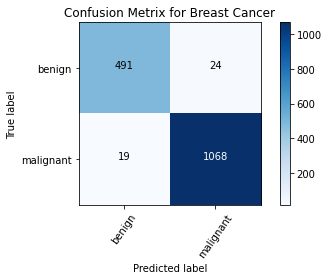

In [27]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

Confusion matrix, without normalization
[[ 482   33]
 [  26 1061]]


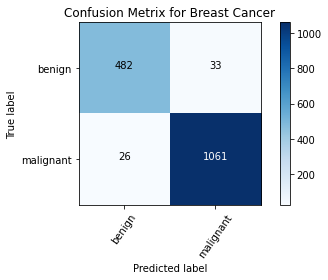

In [28]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

**Classification Report**

In [29]:
from sklearn.metrics import classification_report
classification_report( np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.95      0.94      0.94       515\n           1       0.97      0.98      0.97      1087\n\n    accuracy                           0.96      1602\n   macro avg       0.96      0.96      0.96      1602\nweighted avg       0.96      0.96      0.96      1602\n'

**ROC and AUC**

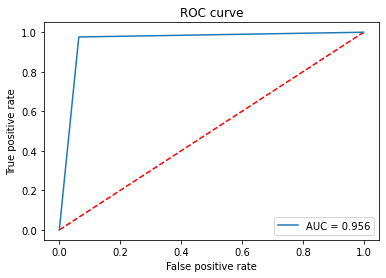

In [30]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_test, axis=1), np.argmax(y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

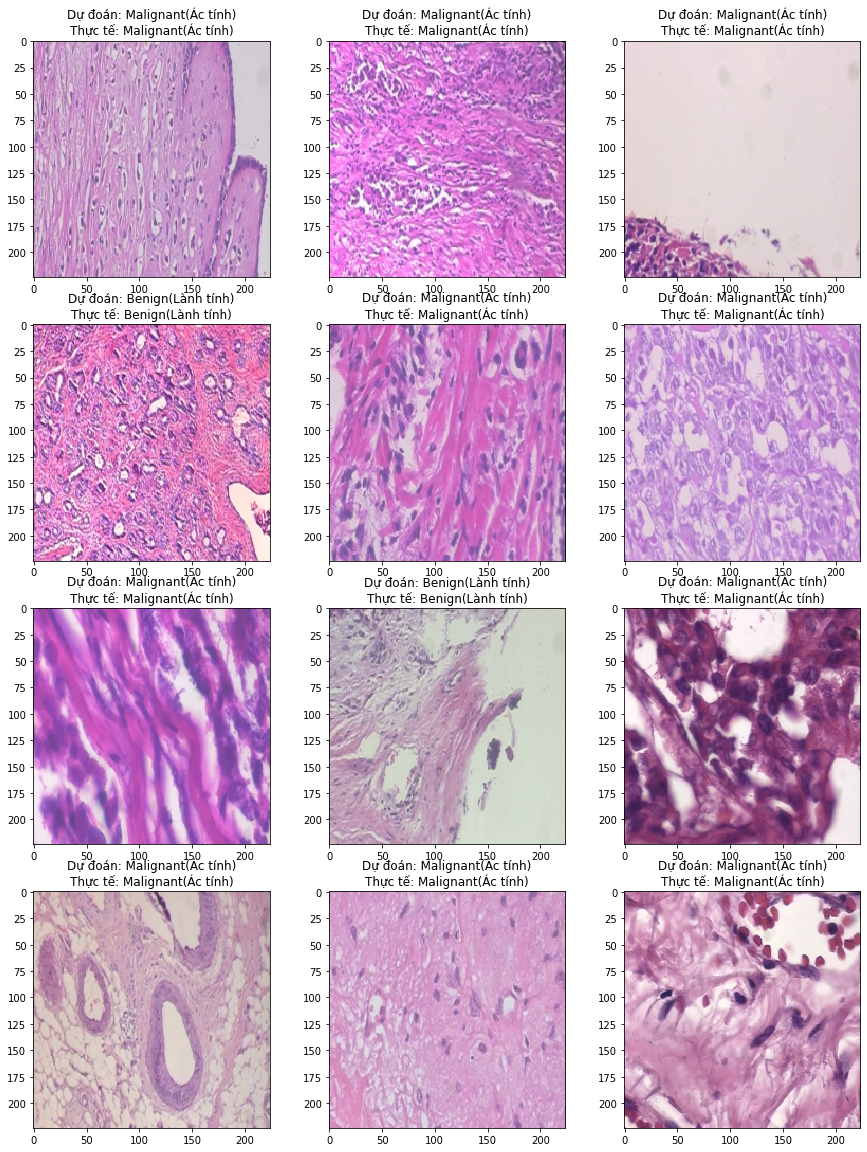

In [31]:
fig=plt.figure(figsize=(15, 20))
columns = 3
rows = 4

def Transfername(namecode):
    if namecode==0:
        return "Benign(Lành tính)"
    else:
        return "Malignant(Ác tính)"
    
for i in range(rows*columns):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.title("Dự đoán: "+ Transfername(np.argmax(y_pred[i])) +"\n"+"Thực tế: "+ Transfername(np.argmax(y_test[i])))
    plt.imshow(X_test[i], interpolation='nearest')
plt.show()